<a href="https://colab.research.google.com/github/vperng/AAI520-NPL-Chatbot/blob/T5-Training/Chatbot_Project_Team6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Generative Chatbot Design

Rene Ortiz, Vivian Perng, Karthik Raghavan

## Project Overview

- Goal: Build a chatbot that can carry out multi-turn conversations, adapt to context, and handle a variety of topics.
- Output: A web or app interface where users can converse with the chatbot.


## Data Collection and Preprocessing

In [1]:
### COMMENT OUT IF NOT USING GOOGLE COLAB ####
import os
from google.colab import drive
drive.mount('/content/drive')

# Set the path to project folder
project_folder = '/content/drive/MyDrive/Colab Notebooks/Chatbot_Project'

# Change the working directory to project folder
os.chdir(project_folder)

# Check the current working directory
print(os.getcwd())

# Install packages that are not on Google Colab here
!pip install datasets
!pip install evaluate
!pip install rouge_score

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Chatbot_Project
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=e9f1b650a17bc8a0e7e3a1c68fc4975506a67163245e880c7b88caf545b63fa5
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [2]:
# Import libraries
import json
import numpy as np
import pandas as pd
import torch
from transformers import T5TokenizerFast, T5ForConditionalGeneration, Trainer, TrainingArguments
from transformers import DataCollatorForSeq2Seq
from datasets import load_dataset, Dataset, DatasetDict
from sklearn.model_selection import train_test_split
from evaluate import load
import matplotlib.pyplot as plt

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')


Using device: cpu


First, some exploration was done to determine the nested structure in the JSON file for the SQuAD dataset. Once the record path was determined, a function was created that flattened the intricate hierarchies into a Pandas dataframe, extracting crucial fields such as ID, question context, answer start, and answers. Furthermore, another feature was added and integrated into the dataframe: the end of each answer. These modifications helped with efficient data management and ensured compatibility with machine learning frameworks.

In [ ]:
# Open files for reading
with open('/content/drive/MyDrive/Colab Notebooks/Chatbot_Project/train-v1.1.json', 'r') as file:
    train_data = json.load(file)
print(type(train_data))

<class 'dict'>


In [ ]:
# Determine type for each key
for key in train_data.keys():
    print(f'Type of value for key "{key}": {type(train_data[key])}')

# Print information about each key
for key in train_data.keys():
    value = train_data[key]
    if isinstance(value, list):
        print(f'Length of list for key "{key}": {len(value)}')
    else:
        print(f'Value for key "{key}": {value}')

Type of value for key "data": <class 'list'>
Type of value for key "version": <class 'str'>
Length of list for key "data": 442
Value for key "version": 1.1


In [ ]:
def explore_record_path(data, path=None):
    """
    Recursively explore the nested structure of a JSON-like object (dict or list) and print the paths
    and types at each level.

    Parameters:
    data (dict or list): The JSON data or a nested structure to explore.
    path (list): A list to track the current record path (used internally for recursion).
    """

    if path is None:
        path = []

    # If the data is a dictionary, print the keys and recursively explore
    if isinstance(data, dict):
        for key in data:
            print(f"{' > '.join(path + [key])}: {type(data[key])}")
            explore_record_path(data[key], path + [key])

    # If the data is a list, print the index and recursively explore the first element
    elif isinstance(data, list) and len(data) > 0:
        print(f"{' > '.join(path)}[]: {type(data[0])}")
        explore_record_path(data[0], path)

# Explore the nested JSON structure to determine record path
explore_record_path(train_data['data'])

[]: <class 'dict'>
title: <class 'str'>
paragraphs: <class 'list'>
paragraphs[]: <class 'dict'>
paragraphs > context: <class 'str'>
paragraphs > qas: <class 'list'>
paragraphs > qas[]: <class 'dict'>
paragraphs > qas > answers: <class 'list'>
paragraphs > qas > answers[]: <class 'dict'>
paragraphs > qas > answers > answer_start: <class 'int'>
paragraphs > qas > answers > text: <class 'str'>
paragraphs > qas > question: <class 'str'>
paragraphs > qas > id: <class 'str'>


In [ ]:
def squad1_json_to_dataframe(file_path, record_path):
    """
    Function to convert the dataset JSON file to a Pandas DataFrame.

    file_path (str): Path to the JSON file
    record_path (list): Path to the deepest level in the JSON structure

    Returns dataFrame containing the parsed data.
    """
    # Load JSON data
    with open(file_path, 'r') as f:
        file_data = json.load(f)

    # Extract and normalize the nested JSON structures
    answers_df = pd.json_normalize(file_data, record_path)
    questions_df = pd.json_normalize(file_data, record_path[:-1])
    paragraphs_df = pd.json_normalize(file_data, record_path[:-2])

    # Add 'answer start' and 'text' from answers_df to questions_df
    questions_df['answer_start'] = answers_df['answer_start']
    questions_df['answers'] = answers_df['text']

    # Create 'context' by repeating the corresponding paragraph for each question
    questions_df['context'] = np.repeat(paragraphs_df['context'].values, paragraphs_df.qas.str.len())

    # Create final DataFrame with necessary columns
    data = questions_df[['id', 'question', 'context', 'answer_start', 'answers']].copy()

    # Add 'c_id' to uniquely identify each context
    data['c_id'] = pd.factorize(data['context'])[0]

    return data.reset_index(drop=True)


In [ ]:
# loading the data
file_path = '/content/drive/MyDrive/Colab Notebooks/Chatbot_Project/train-v1.1.json'
df = squad1_json_to_dataframe(file_path, record_path=['data', 'paragraphs', 'qas', 'answers'])
df

,id,question,context,answer_start,answers,c_id
0,5733be284776f41900661182,To whom did the Virgin Mary allegedly appear i...,"Architecturally, the school has a Catholic cha...",515,Saint Bernadette Soubirous,0
1,5733be284776f4190066117f,What is in front of the Notre Dame Main Building?,"Architecturally, the school has a Catholic cha...",188,a copper statue of Christ,0
2,5733be284776f41900661180,The Basilica of the Sacred heart at Notre Dame...,"Architecturally, the school has a Catholic cha...",279,the Main Building,0
3,5733be284776f41900661181,What is the Grotto at Notre Dame?,"Architecturally, the school has a Catholic cha...",381,a Marian place of prayer and reflection,0
4,5733be284776f4190066117e,What sits on top of the Main Building at Notre...,"Architecturally, the school has a Catholic cha...",92,a golden statue of the Virgin Mary,0
...,...,...,...,...,...,...
87594,5735d259012e2f140011a09d,In what US state did Kathmandu first establish...,"Kathmandu Metropolitan City (KMC), in order to...",229,Oregon,18890
87595,5735d259012e2f140011a09e,What was Yangon previously known as?,"Kathmandu Metropolitan City (KMC), in order to...",414,Rangoon,18890
87596,5735d259012e2f140011a09f,With what Belorussian city does Kathmandu have...,"Kathmandu Metropolitan City (KMC), in order to...",476,Minsk,18890
87597,5735d259012e2f140011a0a0,In what year did Kathmandu create its initial ...,"Kathmandu Metropolitan City (KMC), in order to...",199,1975,18890


In [ ]:
def add_end_position(start_ix, answer):
  """
  This function determines the end position of each answer
  """
  start_position = start_ix
  end_position = start_position + len(answer)
  return end_position

In [ ]:
# add end positions to the dataset
df['answer_end'] = df.apply(lambda x: add_end_position(x['answer_start'], x['answers']), axis=1)
df.head()

,id,question,context,answer_start,answers,c_id,answer_end
0,5733be284776f41900661182,To whom did the Virgin Mary allegedly appear i...,"Architecturally, the school has a Catholic cha...",515,Saint Bernadette Soubirous,0,541
1,5733be284776f4190066117f,What is in front of the Notre Dame Main Building?,"Architecturally, the school has a Catholic cha...",188,a copper statue of Christ,0,213
2,5733be284776f41900661180,The Basilica of the Sacred heart at Notre Dame...,"Architecturally, the school has a Catholic cha...",279,the Main Building,0,296
3,5733be284776f41900661181,What is the Grotto at Notre Dame?,"Architecturally, the school has a Catholic cha...",381,a Marian place of prayer and reflection,0,420
4,5733be284776f4190066117e,What sits on top of the Main Building at Notre...,"Architecturally, the school has a Catholic cha...",92,a golden statue of the Virgin Mary,0,126


## Data Exploration


In [ ]:
# Initialize tokenizer for Flan-T5-Base
tokenizer = T5TokenizerFast.from_pretrained('google/flan-t5-base')

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
def count_tokens(text, tokenizer):
    """
    This function counts the number of tokens in the specified text column of a
    DataFrame using the given tokenizer, and prints the maximum number of tokens
    found in that column.

    Args:
        df: DataFrame containing the text data.
        text (str): Name of column in df that contains the text to be tokenized.
        tokenizer: A tokenizer from the Hugging Face Transformers library.
    """

    df[f'tokens_{text}'] = df[text].apply(lambda x: len(tokenizer.tokenize(x)))

    # Find the maximum number of tokens in the context column
    max_tokens = df[f'tokens_{text}'].max()

    print(f"The maximum number of tokens in the {text} column is: {max_tokens}")

count_tokens('context', tokenizer)
count_tokens('question', tokenizer)
count_tokens('answers', tokenizer)

Token indices sequence length is longer than the specified maximum sequence length for this model (625 > 512). Running this sequence through the model will result in indexing errors


The maximum number of tokens in the context column is: 967
The maximum number of tokens in the question column is: 66
The maximum number of tokens in the answers column is: 75


## Text Preprocessing - T5

For the T5 model, the maximum number of tokens for an input sequence is 512 tokens. This constraint posed a challenge as there are context passages in the dataset that exceed this limit; the maximum token length for context was 967 tokens. Truncating the context could potentially lead to information loss. Therefore, a function was designed to dynamically truncate lengthy contexts while preserving the essential information surrounding the answer span. This involved identifying the token positions of the answer within the context and extracting a window of tokens around it, ensuring the answer remained within the truncated sequence. I tried this method instead of a sliding window to reduce computational costs while training. Then, the text was tokenized in the input format "question: [question text] context: context text]."

In [ ]:
def chunk_context(question_tokenized, context_tokenized, answer_start, answer_end, tokenizer, max_length=510):
    """
    This function extracts a chunk of the context around the answer, while
    ensuring that the total length of the tokenized question and context stays
    within a specified maximum length.

    Args:
        question_tokenized (dict): Tokenized question
        context_tokenized (dict): Tokenized context
        answer_start (int): Start character position of answer in the context
        answer_end (int): End character position of answer in the context
        tokenizer: Tokenizer to decode the tokenized context.
        max_length (int): Max length for tokenized sequence of question/context

    Returns:
        str: Context chunk that includes the answer and surrounding context
    """

    input_ids = context_tokenized['input_ids']
    offsets = context_tokenized['offset_mapping']

    # Find token-level start and end positions of the answer
    token_start_position = next(idx for idx, offset in enumerate(offsets) if offset[0] >= answer_start)
    token_end_position = next(idx for idx, offset in enumerate(offsets) if offset[1] >= answer_end)

    # Calculate available space for context (subtracting question length)
    available_context_length = max_length - len(question_tokenized['input_ids'])

    # Determine how much context to keep around the answer
    half_window_size = (available_context_length - (token_end_position - token_start_position)) // 2
    start_window = max(token_start_position - half_window_size, 0)
    end_window = min(token_end_position + half_window_size, len(input_ids))

    # Extract the relevant context chunk
    truncated_input_ids = input_ids[start_window:end_window]
    truncated_context = tokenizer.decode(truncated_input_ids, skip_special_tokens=True)

    return truncated_context


In [ ]:
def preprocess_function(df, tokenizer, max_length=510):
    """
    Preprocesses a DataFrame containing questions, context, and answers for
    input into a transformer model. This function handles the tokenization of
    questions and contexts, and if the combined length exceeds a given max
    length, it truncates the context using a chunking mechanism that ensures
    the answer remains in the context.

    Args:
        df: DataFrame
        tokenizer: A tokenizer from the Hugging Face Transformers library.
        max_length (int): Max length for tokenized sequence of question/context

    Returns:
        dict: Dictionary containing tokenized inputs and labels
    """

    inputs = []

    # Loop through each row in the DataFrame
    for index, row in df.iterrows():
        question = row['question']
        context = row['context']
        answer_start = row['answer_start']
        answer_text = row['answers']
        answer_end = row['answer_end']

        # Tokenize the question and context, both with their respective prefixes
        question_tokenized = tokenizer(question, truncation=False)
        context_tokenized = tokenizer(context, return_offsets_mapping=True, truncation=False)
        total_length = len(question_tokenized['input_ids']) + len(context_tokenized['input_ids'])

        if total_length > max_length:
            # Call chunk_context to truncate context while retaining the answer
            truncated_context = chunk_context(question_tokenized, context_tokenized, answer_start, answer_end, tokenizer, max_length)
        else:
            truncated_context = context

        # Create the final input with both prefixes
        input_text = f"question: {question} context: {truncated_context}"
        inputs.append(input_text)

    # Tokenize the inputs w/o padding, which will be handled by Data Collator
    model_inputs = tokenizer(inputs, truncation=True, padding="do_not_pad")

    # Tokenize the target answers (labels)
    labels = tokenizer([row['answers'] for _, row in df.iterrows()], max_length=75, truncation=True, padding="max_length")
    model_inputs["labels"] = labels["input_ids"]

    return model_inputs


In [ ]:
# Apply preprocessing to train and validation datasets
tokenized_squad = preprocess_function(df, tokenizer, max_length=510)

In [ ]:
# Save tokenizer
tokenizer.save_pretrained("./T5_tokenizer")

('./T5_tokenizer/tokenizer_config.json',
 './T5_tokenizer/special_tokens_map.json',
 './T5_tokenizer/spiece.model',
 './T5_tokenizer/added_tokens.json',
 './T5_tokenizer/tokenizer.json')

In [ ]:
# Convert the tokenized data to a Hugging Face Dataset
tokenized_dataset = Dataset.from_dict({
    "input_ids": tokenized_squad["input_ids"],
    "attention_mask": tokenized_squad["attention_mask"],
    "labels": tokenized_squad["labels"]
})

In [ ]:
# Split tokenized Hugging Face Datset into train and validation sets
train_val_split = tokenized_dataset.train_test_split(test_size=0.3)

# Create dataset dictionary to handle both train and validation sets
dataset_t5 = DatasetDict({
    'train': train_val_split['train'],
    'validation': train_val_split['test']
})

## Model Design and Training - T5

One of the model architectures that we explored is based on the T5 (Text-To-Text Transfer Transformer) framework. Specifically, it utilizes the T5forConditionalGeneration class from Hugging Face’s Transformers library, which supports sequence-to-sequence tasks. The model is fine-tuned to handle question-answering tasks by taking both the question and context as input. The model is trained and evaluated using Hugging Face’s Trainer API, enabling easy integration of training arguments and a data collator for efficient batching. Hyperparameters were chosen to minimize training times.


In [ ]:
# Load the pre-trained Flan-T5-Base model
model = T5ForConditionalGeneration.from_pretrained('google/flan-t5-base')


config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
# Define training arguments
training_args = TrainingArguments(
    output_dir='./flan-t5-finetuned-squad',  # Directory for saved checkpoints
    per_device_train_batch_size=16, # Chosen for optimal memory usage and speed
    per_device_eval_batch_size=16, # Chosen for optimal memory usage and speed
    num_train_epochs=3,  # Number of epochs for training
    evaluation_strategy="epoch",  # Evaluate at the end of every epoch
    save_steps=10_000,  # Save checkpoint every 10k steps
    save_total_limit=2,  # Only keep the last 2 checkpoints
    learning_rate=3e-5, # Low learning rate for pre-trained model
    warmup_steps=500,  # Warmup steps for learning rate scheduling
    weight_decay=0.01,  # Regularization
    logging_dir='./logs',  # Directory for logs
    logging_steps=500,  # Log every 500 steps
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Define a data collator for seq2seq tasks
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
# Initialize the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_t5['train'],
    eval_dataset=dataset_t5['validation'],
    tokenizer=tokenizer,
    data_collator=data_collator
)


In [ ]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.025100,0.017799
2,0.021900,0.017643
3,0.019900,0.017729


TrainOutput(global_step=11499, training_loss=0.6960623176608545, metrics={'train_runtime': 5272.5578, 'train_samples_per_second': 34.89, 'train_steps_per_second': 2.181, 'total_flos': 8.613581460277248e+16, 'train_loss': 0.6960623176608545, 'epoch': 3.0})

In [ ]:
# Save the fine-tuned model
model.save_pretrained("./flan-t5-finetuned-squad")
tokenizer.save_pretrained("./t5-tokenizer")

('./t5-tokenizer/tokenizer_config.json',
 './t5-tokenizer/special_tokens_map.json',
 './t5-tokenizer/spiece.model',
 './t5-tokenizer/added_tokens.json',
 './t5-tokenizer/tokenizer.json')

## Evaluation - T5

The Flan-T5 model shows consistent improvement in the training loss across epochs, indicating that it is learning effectively during fine-tuning. The training loss decreased from 0.0251 in the first epoch to 0.0199 by the third epoch. Meanwhile, the validation loss started at 0.017799 in the first epoch and gradually reduced to 0.017643 in the second epoch, but slightly increased to 0.017729 in the third epoch. This suggests that while the model is improving its ability to minimize errors during training, the validation performance has begun to plateau after the second epoch.


In [ ]:
# Evaluate the model
trainer.evaluate()

{'eval_loss': 0.01772897131741047,
 'eval_runtime': 207.4769,
 'eval_samples_per_second': 126.665,
 'eval_steps_per_second': 7.919,
 'epoch': 3.0}

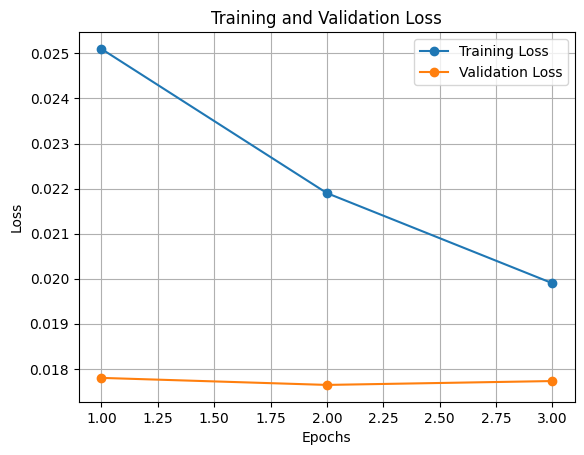

In [ ]:
# Training and validation loss data
epochs = [1, 2, 3]
train_losses = [0.025100, 0.021900, 0.019900]
val_losses = [0.017799, 0.017643, 0.017729]

# Plot the training and validation loss
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

Next, the model was used to make predictions and evaluated on the test set. First, I had the model make predictions based off the questions only to see if the model would be capable of making factually accurate generative answers. The BLEU and ROUGE scores were all very low. When the actual answers and predicted answers were compared, I could see that while the predicted answers were semantically plausible, they were factually incorrect.

Then, I tested the model on its extractive capabilities by inputting the question and context when making predictions, which is ultimately how the model was trained. Here, the fine-tuned model demonstrated strong results in generating accurate and contextually relevant responses. The BLEU score of 0.8407 indicates a strong precision in generating correct outputs. The ROUGE-1 score shows that 90.48% of unigrams in the reference answers were also present in the predictions. The ROUGE-2 score shows that 59.43% of bigrams were captured accurately. The ROUGE-L and ROUGE-Lsum scores of 0.9046 and 0.9048, respectively, suggest that the model effectively captures both the longest common subsequences and the overall structure of the reference answers. Printing the actual answers and predicted answers showed that the model did in fact answer the questions accurately. Overall, the model performed decently, but was not the best model out of all the ones we tried

In [ ]:
# Load the dataset, specifying it as the test split
test_dataset = load_dataset('json', data_files={'test': '/content/drive/MyDrive/Colab Notebooks/Chatbot_Project/dev-v1.1.json'}, field='data')

# Verify that the dataset loaded correctly
print(test_dataset)

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['title', 'paragraphs'],
        num_rows: 48
    })
})


In [ ]:
def preprocess_test_questions(examples):
    """
    This function preprocesses the test dataset by extracting questions from a
    nested structure and preparing them in the "question: [question]" format.
    The resulting questions are then tokenized.

    Args:
        examples: Dictionary containing paragraphs with nested questions.

    Returns:
        dict: Dictionary of tokenized questions suitable for input into model.
    """

    # Extract questions from the nested structure
    questions = []

    # Access the paragraphs field (already a single example)
    for paragraph in examples['paragraphs']:
        # Extract questions from qas inside the paragraph
        for qa in paragraph['qas']:
            questions.append("question: " + qa['question'])

    # Tokenize the questions
    model_inputs = tokenizer(questions, max_length=512, truncation=True, padding="max_length")

    return model_inputs


In [ ]:
# Tokenize the test split of the dataset
tokenized_test_dataset = test_dataset['test'].map(preprocess_test_questions, batched=False, remove_columns=["paragraphs"])


Map:   0%|          | 0/48 [00:00<?, ? examples/s]

In [ ]:
def generate_predictions(tokenized_test_dataset):
    '''
    This function generates predictions for a given tokenized test dataset.

    Parameters:
    tokenized_test_dataset: A tokenized dataset where each example contains
    input_ids and attention masks necessary for model inference.

    Returns:
    predictions (list): A list of decoded predictions generated by the model
    '''

    predictions = []

    # Loop through each example in the tokenized test dataset
    for i in range(len(tokenized_test_dataset)):

        # Access individual example
        example = tokenized_test_dataset[i]

        # If there are multiple sequences, iterate over each sequence
        for seq_index in range(len(example['input_ids'])):
            input_ids = torch.tensor(example['input_ids'][seq_index], dtype=torch.long).unsqueeze(0).to(device)
            attention_mask = torch.tensor(example['attention_mask'][seq_index], dtype=torch.long).unsqueeze(0).to(device)

            # Generate predictions using the model
            outputs = model.generate(input_ids, attention_mask=attention_mask, max_length=100, num_beams=4, early_stopping=True)

            # Decode the predicted output into text
            decoded_pred = tokenizer.decode(outputs[0], skip_special_tokens=True)

            # Append the prediction to the list
            predictions.append(decoded_pred)

    return predictions

In [ ]:
# Generate predictions for the test dataset
predictions = generate_predictions(tokenized_test_dataset)

In [ ]:
# Extract multiple reference answers for each question from the test dataset
references = []

# Loop through the test dataset and collect the reference answers
for example in test_dataset['test']:
    # Loop through paragraphs and then through qas
    for paragraph in example['paragraphs']:
        for qa in paragraph['qas']:
            # Extract all valid answers for the current question
            current_references = [answer['text'] for answer in qa['answers']]
            references.append(current_references)



In [ ]:
# Load BLEU metric
bleu_metric = load("bleu")
rouge_metric = load("rouge")

In [ ]:
# Compute the BLEU score directly on plain text
bleu_results = bleu_metric.compute(predictions=predictions, references=references)
print("BLEU Score:", bleu_results['bleu'])

# Compute the ROUGE score directly on plain text
rouge_results = rouge_metric.compute(predictions=predictions, references=references)
print("ROUGE Scores:", rouge_results)

BLEU Score: 0.02350549896150287
ROUGE Scores: {'rouge1': 0.1045025947615909, 'rouge2': 0.01745895815538697, 'rougeL': 0.10327531290022487, 'rougeLsum': 0.10325487161359242}


In [ ]:
# Number of examples to check
n_examples = 20

# Keep track of index across paragraphs and questions
prediction_idx = 0

# Loop through paragraphs and questions
for paragraph_idx, paragraph in enumerate(test_dataset['test']):
    for qa_idx, qa in enumerate(paragraph['paragraphs'][0]['qas']):

        # Extract the question and context from the test dataset
        question = qa['question']
        context = paragraph['paragraphs'][0]['context']

        # Extract the corresponding prediction and reference answers
        prediction = predictions[prediction_idx]
        reference_answers = references[prediction_idx]

        # Print out the aligned prediction, question, context, and references
        print(f"Example {prediction_idx + 1}:")
        print(f"Question: {question}")
        print(f"Context: {context}")
        print(f"Prediction: {prediction}")
        print(f"Reference Answers: {reference_answers}")
        print("=" * 50)

        # Move to the next prediction
        prediction_idx += 1

        # Stop after the desired number of examples
        if prediction_idx >= n_examples:
            break
    if prediction_idx >= n_examples:
        break


Example 1:
Question: Which NFL team represented the AFC at Super Bowl 50?
Context: Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.
Prediction: Dallas Cowboys
Reference Answers: ['Denver Broncos', 'Denver Broncos', 'Denver Broncos']
Example 2:
Question: Which NFL team repr

The model was also evaluated on its predictions when given the question and context.

In [ ]:
def preprocess_test_w_context(examples):
    """
    This function preprocesses the test dataset by extracting questions and
    context from a nested structure and formatting them into the
    "question: [question] context: [context]" format. The resulting inputs are
    then tokenized for model consumption.

    Args:
        examples: Dictionary containing paragraphs with nested questions/context.

    Returns:
        dict: Dictionary of tokenized inputs suitable for input into model.
    """

    # Extract questions and context from the nested structure
    inputs = []

    # Iterate through each paragraph in the examples
    for paragraph in examples['paragraphs']:
        context = paragraph['context']  # Extract the context

        # For each question in the 'qas' field
        for qa in paragraph['qas']:
            question = qa['question']  # Extract the question

            # Prepare the input text in the "question: context:" format
            input_text = f"question: {question} context: {context}"

            # Append the prepared text to the inputs list
            inputs.append(input_text)

    # Tokenize the inputs (questions with context)
    model_inputs = tokenizer(inputs, max_length=512, truncation=True, padding="max_length")

    return model_inputs

In [ ]:
# Preprocess question and context from test dataset
tokenized_test_context = test_dataset['test'].map(preprocess_test_w_context, batched=False, remove_columns=["paragraphs"])

In [ ]:
# Generate predictions given question and context
predictions_context = generate_predictions(tokenized_test_context)

In [ ]:
# Load BLEU metric
bleu_metric = load("bleu")
rouge_metric = load("rouge")

# Compute the BLEU score without manual tokenization
bleu_results = bleu_metric.compute(predictions=predictions_context, references=references)
print("BLEU Score:", bleu_results['bleu'])

# Compute the ROUGE score directly on plain text
rouge_results = rouge_metric.compute(predictions=predictions_context, references=references)
print("ROUGE Scores:", rouge_results)

BLEU Score: 0.8406594745259233
ROUGE Scores: {'rouge1': 0.9047930093457501, 'rouge2': 0.5942539485702308, 'rougeL': 0.9046121033295109, 'rougeLsum': 0.9047614132389385}


In [ ]:
# Number of examples to check
n_examples = 20  # Adjust this based on how many samples you want to check

# Keep track of index across paragraphs and questions
prediction_idx = 0

# Loop through paragraphs and questions
for paragraph_idx, paragraph in enumerate(test_dataset['test']):
    for qa_idx, qa in enumerate(paragraph['paragraphs'][0]['qas']):

        # Extract the question and context from the test dataset
        question = qa['question']
        context = paragraph['paragraphs'][0]['context']

        # Extract the corresponding prediction and reference answers
        prediction = predictions_context[prediction_idx]
        reference_answers = references[prediction_idx]  # This contains multiple references

        # Print out the aligned prediction, question, context, and references
        print(f"Example {prediction_idx + 1}:")
        print(f"Question: {question}")
        print(f"Context: {context}")
        print(f"Prediction: {prediction}")
        print(f"Reference Answers: {reference_answers}")
        print("=" * 50)

        # Move to the next prediction
        prediction_idx += 1

        # Stop after the desired number of examples
        if prediction_idx >= n_examples:
            break
    if prediction_idx >= n_examples:
        break

Example 1:
Question: Which NFL team represented the AFC at Super Bowl 50?
Context: Super Bowl 50 was an American football game to determine the champion of the National Football League (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title. The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara, California. As this was the 50th Super Bowl, the league emphasized the "golden anniversary" with various gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game with Roman numerals (under which the game would have been known as "Super Bowl L"), so that the logo could prominently feature the Arabic numerals 50.
Prediction: Denver Broncos
Reference Answers: ['Denver Broncos', 'Denver Broncos', 'Denver Broncos']
Example 2:
Question: Which NFL team repr

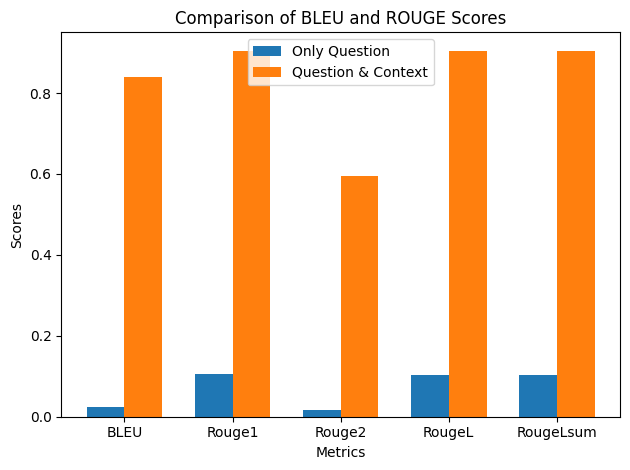

In [ ]:
# Data for plotting
metrics = ["BLEU", "Rouge1", "Rouge2", "RougeL", "RougeLsum"]
question_given_scores_list = [0.02350549896150287, 0.1045025947615909,
                              0.01745895815538697, 0.10327531290022487,
                              0.10325487161359242]
question_context_given_scores_list = [0.8406594745259233, 0.9047930093457501,
                                      0.5942539485702308, 0.9046121033295109,
                                      0.9047614132389385]

# Bar width and position
bar_width = 0.35
index = np.arange(len(metrics))

# Create the bar graph
plt.bar(index, question_given_scores_list, bar_width, label='Only Question')
plt.bar(index + bar_width, question_context_given_scores_list, bar_width, label='Question & Context')

# Adding labels and title
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Comparison of BLEU and ROUGE Scores')
plt.xticks(index + bar_width / 2, metrics)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


## Evaluation of T5 vs DistilGPT

The BLEU and ROUGE scores for the DistilGPT2 model are clearly superior over the Flan T5 model. While both models performed well, we will move forward with the DistilGPT2 model.

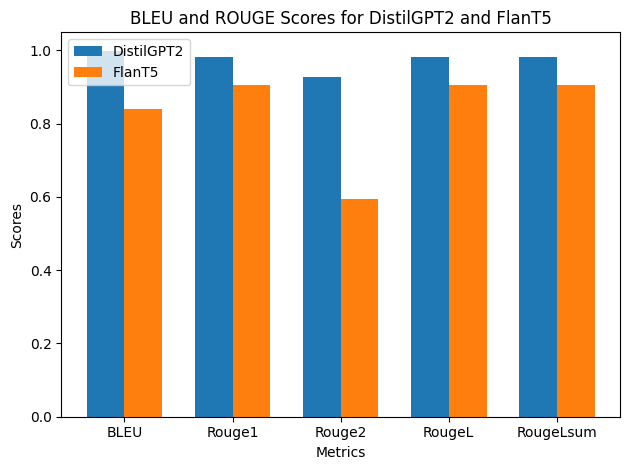

In [3]:
# Data for plotting
metrics = ["BLEU", "Rouge1", "Rouge2", "RougeL", "RougeLsum"]
gpt = [0.9995, 0.9817, 0.9287, 0.9817, 0.9817]
t5 = [0.8407, 0.9048, 0.5943, 0.9046, 0.9048]

# Bar width and position
bar_width = 0.35
index = np.arange(len(metrics))

# Create the bar graph
plt.bar(index, gpt, bar_width, label='DistilGPT2')
plt.bar(index + bar_width, t5, bar_width, label='FlanT5')

# Adding labels and title
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('BLEU and ROUGE Scores for DistilGPT2 and FlanT5')
plt.xticks(index + bar_width / 2, metrics)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()


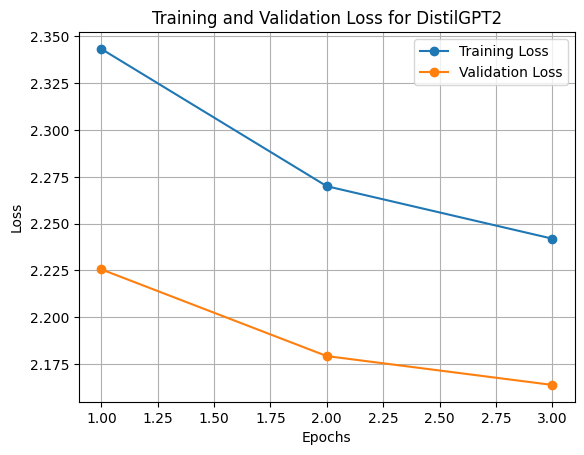

In [4]:
# Training and validation loss data for DistilGPT2
epochs = [1, 2, 3]
train_losses = [2.3433, 2.2700, 2.2420]
val_losses = [2.2256, 2.1793, 2.1639]

# Plot the training and validation loss
plt.plot(epochs, train_losses, label="Training Loss", marker="o")
plt.plot(epochs, val_losses, label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss for DistilGPT2")
plt.legend()
plt.grid(True)
plt.show()